In [1]:
from Modeling import model
from mygp import gp, kernel
import numpy as np
import batman 
import warnings
import matplotlib.pyplot as pl
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
pl.style.use('seaborn-deep')

import warnings
warnings.simplefilter('ignore')

import sys
sys.path.insert(0, '/Users/tgordon/research/libra/')
from libra import ObservationArchive, nirspec_pixel_wavelengths
import corner
import utilities

In [2]:
def transit(t, log_off, b, rp, t0, dt):
    
    t = np.array(t)
    T0 = dt*np.sqrt(1-b**2)/(1 - b**2 + rp)
    
    params = batman.TransitParams()
    params.t0 = t0                       
    params.per = 100                      
    params.rp = rp                      
    params.a = params.per/(T0*np.pi)                       
    params.inc = np.arccos(b/params.a)*(180/np.pi)                     
    params.ecc = 0.                      
    params.w = 90. 
    
    u1, u2 = 0.1, 0.3
    d4 = -u2
    d2 = u1 + 2*u2
    d1, d3 = 0, 0
    
    params.u = [u1, u2]                
    params.limb_dark = "quadratic" 
    
    m = batman.TransitModel(params, t)    
    return log_off*m.light_curve(params)


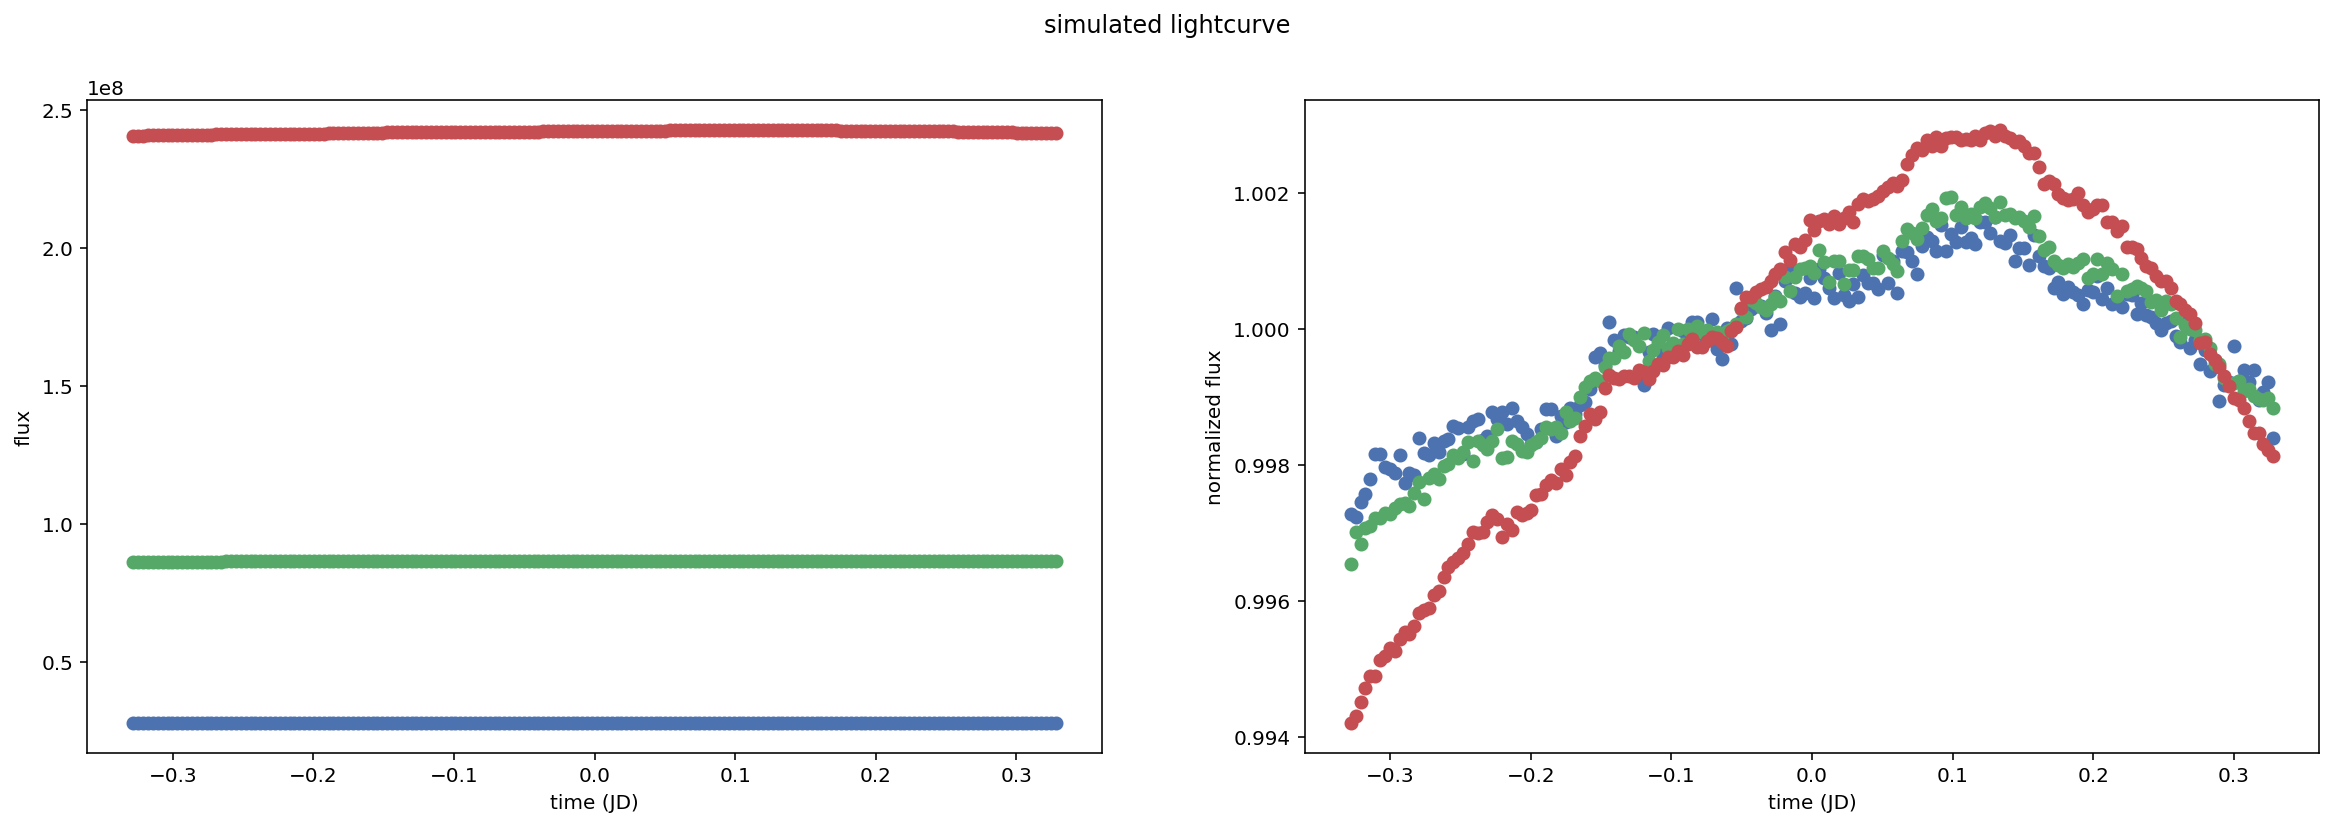

In [3]:
# get and plot data

basedir = '/Users/tgordon/research/libra/notebooks/'
data = np.loadtxt(basedir + 'tyler9_b_binned_small.txt')
t = data[0] - np.median(data[0])

figure = pl.figure(figsize=(12, 10))
data = data[::-1]
data = data[:-1]

utilities.plot_samples(data, t, 'simulated lightcurve');

In [4]:
k1_params = [0.2, 6e9]
k2_params = [5, 20]
white_noise = [2e3]*3
offsets = [np.median(data[0]), np.median(data[1]), np.median(data[2])]
mean_params = [0.0, 0.0, 0.0, 0.1]

transit_model = model(k1_params, k2_params, white_noise, mean_params, offsets, transit, 
                        kernel.celerite_root2_kernel, kernel.scale_kernel, 3)

transit_model.fit_variability(data, t, method='L-BFGS-B')

(array([-1.61109359, 22.51553988,  1.5118162 ,  3.09257291,  7.60198139,
         7.62131846,  7.6028729 , 17.14107372, 18.27489976, 19.30385661]),
 11116.697326502675)

In [ ]:
def compute_like_dur(t0, n):
    dur = np.linspace(0.01, 0.1, n)
    log_likelihood = []
    for d in dur:
        mean_params = [0.0, 0.0175, t0, d]
        transit_model.update_gp(mean_params=mean_params)
        transit_model.gp.compute(t)
        log_likelihood.append(transit_model.gp.log_likelihood(data, t))
    return dur, log_likelihood

In [ ]:
t0 = np.linspace(-0.15, -0.25, 10)
for c in t0:
    d, l = compute_like_dur(c, 200)
    pl.plot(d, l, '-', label=str(c))
pl.legend()

In [ ]:
mean_params = [0.0, 0.018, -0.194, 0.06]
transit_model.update_gp(mean_params=mean_params)
transit_model.fit(data, t)
transit_model.print_params()

In [ ]:
n = 20
tau = np.linspace(0.01, 1, n)
amp = np.logspace(8, 12, n)

def func(l, a):
    transit_model.update_gp(k1_params = [l, a])
    transit_model.gp.compute(t)
    return transit_model.gp.log_likelihood(data, t)

like = utilities.plot_likelihood(func, amp, tau)

In [ ]:
fig = pl.figure(figsize=(10, 10))
pl.pcolormesh(np.log10(amp), tau, like, vmin=np.max(like)-100)
pl.xlabel('log(amplitude)')
pl.ylabel('variability timescale (days)')
pl.title('likelihood')

# optimization results
#pl.axvline(np.log10(5.11530049e+09), color='r', linewidth=5)
#pl.axhline(1.82742586e-01, color='r', linewidth=5)

In [ ]:
def func(tau, d):
    transit_model.update_gp(mean_params=[0, d, tau, 0.04])
    transit_model.gp.compute(t)
    return transit_model.gp.log_likelihood(data, t)

depths = np.linspace(0.0, 0.03, 5)
t0 = np.linspace(t.min(), t.max(), 100)
like = utilities.plot_likelihood(func, t0, depths)

#f = lambda t: func(t, 0.0275)
#like = [f(t) for t in t0]
#pl.plot(t0, like)

In [ ]:
#fig = pl.figure(figsize=(10, 8))
#pl.plot(t0, like, '.')
#pl.axvline(-0.08, color='k')

In [ ]:
figure = pl.figure(figsize=(10, 10))
pl.pcolormesh(t0, depths, like, vmin=np.max(like)-1000)
pl.title('likelihood')
pl.xlabel('Transit Center')
pl.ylabel('Rp/Rstar')

In [ ]:
fig = pl.figure(figsize=(10, 10))
pl.pcolormesh(t0, depth, like, vmin=np.max(like)-100)
pl.xlabel('center of transit')
pl.ylabel('transit depth')
pl.title('likelihood')

In [ ]:
pl.figure(figsize=(12, 8))
pl.plot(t, data[2]/np.median(data[2]), 'o', label='data')
pl.plot(t, data[2]/np.median(data[2]) - transit(t, 1, 0, 0.02, -0.194, 0.06) + 1, '.k', label='transit subtracted')
#pl.ylim(0.999, 1.00)
#pl.xlim(0, 0.2)

pl.title('Tyler6_b')
pl.xlabel('time (days)')
pl.ylabel('relative flux')
pl.legend()
pl.text(0.15, 1.003, 'Depth: {:.2f}\nDuration: {:.2f}\nCenter: {:.2f}'.format(0.021, 0.05, 0.09), fontsize=15)

In [14]:
import sys
sys.path.insert(0, '/Users/tgordon/research/libra/libra/')
from libra import ObservationArchive, nirspec_pixel_wavelengths
with ObservationArchive("tyler3_b", 'r') as obs:
    observation = obs.b[0]
    total_flux = np.sum(observation.spectra, axis=1) # Sum along wavelength axis
    plt.plot(observation.times, total_flux, '.', alpha=0.5)
    plt.xlabel('Time [BJD]')
    plt.ylabel('NIRSpec Counts')

ImportError: cannot import name 'ObservationArchive'